In [2]:
import numpy as np
import cv2

def parse_calib_line(line):
    return np.array([float(x) for x in line.strip().split(' ')[1:]])

def to_homogeneous(mat3x4):
    return np.vstack([mat3x4, [0, 0, 0, 1]])

# ----- Calibration Data from KITTI -----
P2 = parse_calib_line("P2: 7.215377e+02 0 6.095593e+02 4.485728e+01 0 7.215377e+02 1.728540e+02 2.163791e-01 0 0 1 2.745884e-03").reshape(3, 4)
R0_rect = parse_calib_line("R0_rect: 9.999239e-01 9.837760e-03 -7.445048e-03 -9.869795e-03 9.999421e-01 -4.278459e-03 7.402527e-03 4.351614e-03 9.999631e-01").reshape(3, 3)
Tr_cam_to_road = parse_calib_line("Tr_cam_to_road: 9.999045e-01 -1.170166e-02 -7.360827e-03 1.911985e-02 1.160252e-02 9.998433e-01 -1.336987e-02 -1.562198e+00 7.516123e-03 1.328319e-02 9.998835e-01 2.752776e-01").reshape(3, 4)

# Convert to 4x4 matrices
P2 = to_homogeneous(P2)
R0_rect_4x4 = np.eye(4)
R0_rect_4x4[:3, :3] = R0_rect
Tr_cam_to_road = to_homogeneous(Tr_cam_to_road)

# Inverse projection matrix
P2_inv = np.linalg.inv(P2 @ R0_rect_4x4)

In [10]:
gt_folder = r"data\labels"
img_name = "mask_um_lane_000000.png"
img = cv2.imread(f"{gt_folder}/{img_name}", cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(255*img, cv2.COLOR_GRAY2BGR)

# cv2.imshow("gt", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

img = np.concatenate((img, 255*np.ones((*img.shape[:2], 1), dtype=img.dtype)), axis=-1)
H, W, _ = img.shape

In [11]:
# ----- Step 2: Reshape and backproject -----
pixels_flat = img.reshape(-1, 4).T  # shape (4, H*W)

# ----- Step 3: Backproject to camera space -----
rays_cam = P2_inv @ pixels_flat  # shape (4, H*W)
rays_cam /= rays_cam[3, :]       # normalize homogeneous coords

# ----- Step 4: Transform to road (BEV) frame -----
rays_world = Tr_cam_to_road @ rays_cam  # shape (4, H*W)

# ----- Step 5: Extract BEV coordinates -----
bev_coords = rays_world[:2, :].T.reshape(H, W, 2)  # (H, W, 2)

print("BEV grid shape:", bev_coords.shape)
print("BEV sample at center pixel:", bev_coords[H//2, W//2])

BEV grid shape: (375, 1242, 2)
BEV sample at center pixel: [-0.04072322 -1.56310464]


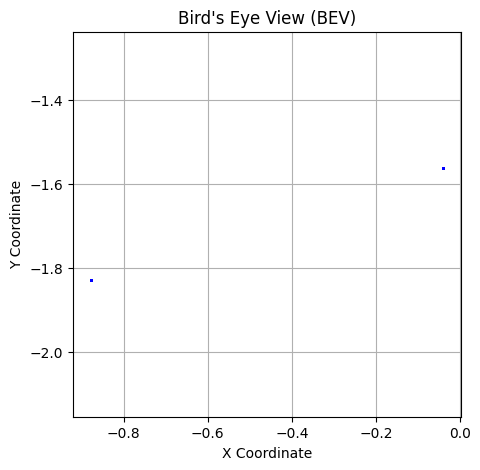

In [13]:
import matplotlib.pyplot as plt

# Extract X and Y coordinates
x_coords = bev_coords[:, :, 0].flatten()
y_coords = bev_coords[:, :, 1].flatten()

# Plot the BEV
plt.figure(figsize=(5, 5))
plt.scatter(x_coords, y_coords, s=1, c='blue', alpha=0.5)
plt.title("Bird's Eye View (BEV)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.axis('equal')
plt.grid(True)
plt.show()